[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaloADBA/ELE8812-demos/blob/main/Demos/Lesson%204/Leçon_4_Demo_detr1.ipynb)

# ELE8812 - Traitement fréquentielle

## Démo : Détramage par filtrage passe-bande

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Option d'affichage
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
!git clone https://github.com/MaloADBA/ELE8812-demos.git Repo

Cloning into 'Repo'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 189 (delta 21), reused 72 (delta 17), pack-reused 93
Receiving objects: 100% (189/189), 23.28 MiB | 7.68 MiB/s, done.
Resolving deltas: 100% (33/33), done.


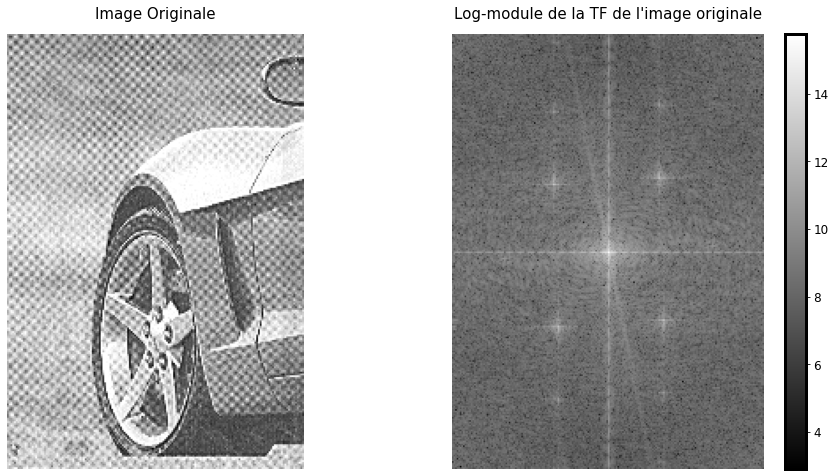

In [3]:
# Charger image
A = plt.imread('Repo/Data/Voiture.tif');

# Transformée de Fourier
pad = 30;
Me, Ne = A.shape
AA = np.fft.fftshift(np.fft.fft2(np.double(A), (Me + pad, Ne + pad)))

plt.subplot(121); plt.imshow(A, cmap='gray'); plt.title('Image Originale'); plt.axis('off');
plt.subplot(122); plt.imshow(np.log(np.abs(AA)), cmap='gray'); plt.colorbar(); plt.title("Log-module de la TF de l'image originale"); plt.axis('off'); plt.show();

## Paramètres de filtrage

In [4]:
largeur = 20 # largeur de la bande
fc1 = 56.8 # fréquence centrale de la bande coupée
fc2 = 99.2 # fréquence centrale de la bande coupée

## Filtrage passe-bande

In [12]:
# Création du filtre
M, N = AA.shape

M0 = np.ceil((M+1) / 2)
N0 = np.ceil((N+1) / 2)

U, V = np.mgrid[1:M+1, 1:N+1]
D2 = (U - M0)**2 + (V - N0)**2

HH1g = 1 - np.exp(- (D2 - fc1**2)**2 / (largeur**2 * D2 ))**2
HH2g = 1 - np.exp(- (D2 - fc2**2)**2 / (largeur**2 * D2 ))**2

# Application du passe bande dans le domaine fréquentiel
BBg = AA * HH1g * HH2g

# Reconstruction de l'image après filtrage
Bg = np.fft.ifft2(np.fft.ifftshift(BBg))

<ipython-input-12-1ac74fcf3fa5>:10: RuntimeWarning: divide by zero encountered in true_divide
  HH1g = 1 - np.exp(- (D2 - fc1**2)**2 / (largeur**2 * D2 ))**2
<ipython-input-12-1ac74fcf3fa5>:11: RuntimeWarning: divide by zero encountered in true_divide
  HH2g = 1 - np.exp(- (D2 - fc2**2)**2 / (largeur**2 * D2 ))**2


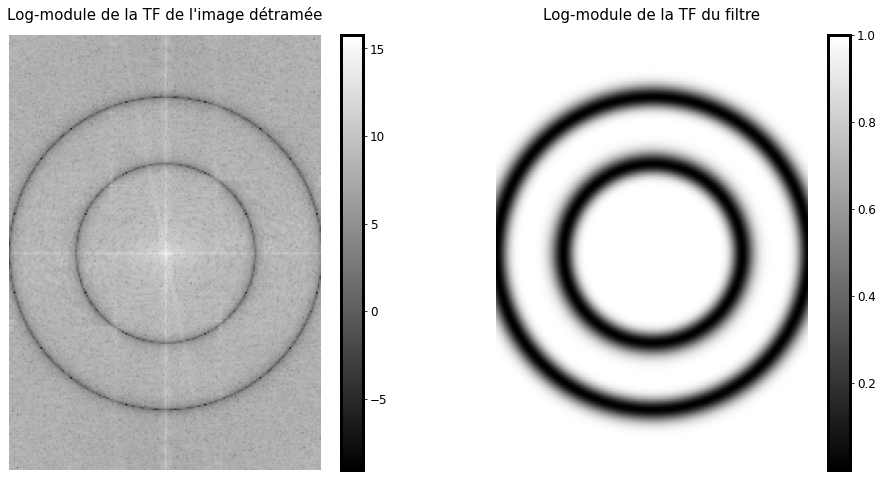

In [13]:
plt.subplot(121); plt.imshow(np.log(np.abs(BBg)), cmap='gray'); plt.colorbar(); plt.axis('off'); plt.title("Log-module de la TF de l'image détramée");
plt.subplot(122); plt.imshow(HH1g*HH2g, cmap='gray'); plt.colorbar(); plt.axis('off'); plt.title('Log-module de la TF du filtre');
plt.show()

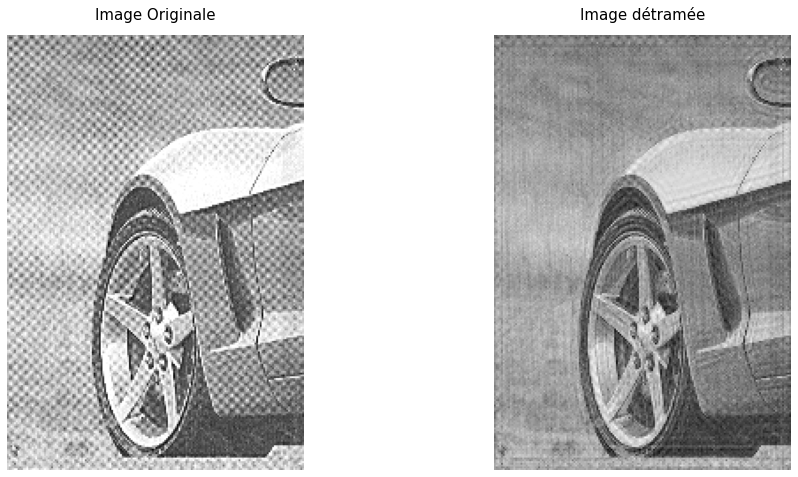

In [14]:
plt.subplot(121); plt.imshow(A, cmap='gray'); plt.title('Image Originale'); plt.axis('off');
plt.subplot(122); plt.imshow(np.real(Bg[:Me,:Ne]), cmap='gray'); plt.axis('off'); plt.title('Image détramée'); plt.show()